<h1 style="color: green">Beijing Air Quality Data (2010-15)</h1>
<h1 style="font-size:32px;">SEVERE POLLUTION MODEL </h1>
Severe Pollution: PM2.5 >= 300

<hr>

## Table of Contents
* [1. Data Preparation](#dataprep)
* [2. Gradient Boosting Model](#gbmodel)
* [3. Logistic Regression Model](#logitmodel)
* [4. Warning Level Analysis](#warning)
        
<hr>

# 1. Data Preparation<a class="anchor" id="dataprep"></a>

In [111]:
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [112]:
beijing = pd.read_csv("beijing.csv")
beijing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 14 columns):
No             43824 non-null int64
year           43824 non-null int64
month          43824 non-null int64
day            43824 non-null int64
hour           43824 non-null int64
pm2.5          41757 non-null float64
DEWP           43824 non-null int64
TEMP           43824 non-null float64
PRES           43824 non-null float64
cbwd           43824 non-null object
Iws            43824 non-null float64
Is             43824 non-null int64
Ir             43824 non-null int64
model_pm2.5    43824 non-null float64
dtypes: float64(5), int64(8), object(1)
memory usage: 4.7+ MB


In [113]:
# Convert to Datetime
def dmyh2datetime(x):
    s = "{day:02d}-{month:02d}-{year:04d} {hour:02d}".format(**x)
    return pd.to_datetime(s,format="%d-%m-%Y %H")
beijing.index = pd.Index(beijing.apply(dmyh2datetime , axis=1),name="day_hour")

In [114]:
beijing = pd.get_dummies(beijing)

In [115]:
daily = beijing.drop(["No","year","month","day","hour","pm2.5"],axis=1).resample('D').mean()

In [116]:
daily['severe'] = (beijing.resample('D')['model_pm2.5'].max().values >= 300).astype('int')

Severe Pollution State Sticky


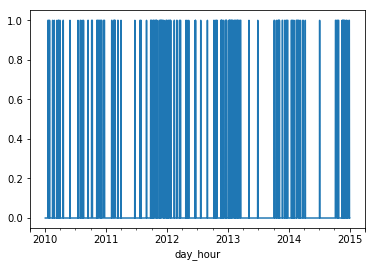

In [117]:
print('Severe Pollution State Sticky')
ax = daily['severe'].plot()

In [118]:
pd.crosstab(daily['severe'].shift(-1).rename('severe prior'),daily['severe'])

severe,0,1
severe prior,,
0.0,1465,112
1.0,112,136


In [119]:
hilo = ['DEWP','TEMP','PRES','Iws','Ir','Is','model_pm2.5']
daily[[col+"_hi" for col in hilo]] = beijing[hilo].resample('D').max()
daily[[col+"_lo" for col in hilo]] = beijing[hilo].resample('D').min()

In [120]:
pm_values = ['model_pm2.5','model_pm2.5_hi','model_pm2.5_lo']
daily[pm_values] = daily[pm_values].shift(-1)

In [121]:
daily.head()

,DEWP,TEMP,PRES,Iws,Is,Ir,model_pm2.5,cbwd_NE,cbwd_NW,cbwd_SE,...,Ir_hi,Is_hi,model_pm2.5_hi,DEWP_lo,TEMP_lo,PRES_lo,Iws_lo,Ir_lo,Is_lo,model_pm2.5_lo
day_hour,,,,,,,,,,,,,,,,,,,,,
2010-01-01,-18.750000,-6.750000,1017.083333,14.458333,0.000000,0.0,145.958333,0.041667,0.833333,0.00,...,0,0,181.0,-21,-14.0,1014.0,0.89,0,0,105.0
2010-01-02,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,78.833333,0.000000,0.000000,1.00,...,0,4,107.0,-16,-6.0,1020.0,1.79,0,0,53.0
2010-01-03,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,31.333333,0.000000,0.166667,0.75,...,0,27,79.0,-12,-11.0,1020.0,0.89,0,0,20.0
2010-01-04,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,42.458333,0.000000,1.000000,0.00,...,0,0,106.0,-26,-15.0,1023.0,16.09,0,0,25.0
2010-01-05,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,56.416667,0.375000,0.583333,0.00,...,0,0,132.0,-27,-19.0,1031.0,0.89,0,0,20.0


In [122]:
cbwd = ['cbwd_NW', 'cbwd_NE', 'cbwd_SE', 'cbwd_cv']
daily[[col+"_ma7d" for col in cbwd]] = daily[cbwd].rolling('7D',min_periods=7).mean()

In [123]:
daily['pm2.5_ma7d'] = daily['model_pm2.5'].rolling('7D',min_periods=7).mean()

In [124]:
daily = daily.dropna()

In [125]:
daily.describe()

,DEWP,TEMP,PRES,Iws,Is,Ir,model_pm2.5,cbwd_NE,cbwd_NW,cbwd_SE,...,PRES_lo,Iws_lo,Ir_lo,Is_lo,model_pm2.5_lo,cbwd_NW_ma7d,cbwd_NE_ma7d,cbwd_SE_ma7d,cbwd_cv_ma7d,pm2.5_ma7d
count,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,...,1819.000000,1819.000000,1819.000000,1819.0,1819.00000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000
mean,1.894791,12.529870,1016.404618,23.725817,0.044759,0.195666,98.461136,0.113959,0.321926,0.349276,...,1013.688290,3.816251,0.002199,0.0,47.62906,0.322001,0.114175,0.349450,0.214374,98.390231
std,14.134799,11.503164,10.062162,41.231053,0.435086,0.995492,76.755483,0.124281,0.288204,0.261028,...,9.895334,22.659840,0.093787,0.0,54.78238,0.178473,0.055497,0.169287,0.072003,44.813262
min,-33.333333,-12.500000,994.041667,1.412500,0.000000,0.000000,2.958333,0.000000,0.000000,0.000000,...,991.000000,0.450000,0.000000,0.0,0.00000,0.000000,0.005952,0.005952,0.017857,25.763540
25%,-10.000000,1.625000,1007.895833,5.868125,0.000000,0.000000,42.645833,0.041667,0.083333,0.125000,...,1005.000000,0.890000,0.000000,0.0,11.00000,0.190476,0.077381,0.208333,0.166667,68.494048
50%,2.125000,14.000000,1016.125000,10.913750,0.000000,0.000000,79.208333,0.083333,0.250000,0.333333,...,1013.000000,0.890000,0.000000,0.0,29.00000,0.291667,0.107143,0.357143,0.208333,88.202494
75%,15.083333,23.208333,1024.416667,22.098333,0.000000,0.000000,130.895833,0.166667,0.500000,0.541667,...,1022.000000,0.890000,0.000000,0.0,63.00000,0.434524,0.142857,0.476190,0.255952,118.964286
max,26.208333,32.875000,1043.458333,463.187917,8.708333,17.583333,540.995665,0.958333,1.000000,1.000000,...,1040.000000,359.870000,4.000000,0.0,407.00000,0.886905,0.404762,0.809524,0.684524,346.107603


In [126]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1819 entries, 2010-01-07 to 2014-12-30
Freq: D
Data columns (total 31 columns):
DEWP              1819 non-null float64
TEMP              1819 non-null float64
PRES              1819 non-null float64
Iws               1819 non-null float64
Is                1819 non-null float64
Ir                1819 non-null float64
model_pm2.5       1819 non-null float64
cbwd_NE           1819 non-null float64
cbwd_NW           1819 non-null float64
cbwd_SE           1819 non-null float64
cbwd_cv           1819 non-null float64
severe            1819 non-null int64
DEWP_hi           1819 non-null int64
TEMP_hi           1819 non-null float64
PRES_hi           1819 non-null float64
Iws_hi            1819 non-null float64
Ir_hi             1819 non-null int64
Is_hi             1819 non-null int64
model_pm2.5_hi    1819 non-null float64
DEWP_lo           1819 non-null int64
TEMP_lo           1819 non-null float64
PRES_lo           1819 non-null float

In [127]:
dropped = []
predictors = list(daily.drop(['severe']+dropped, axis=1).columns)
X = daily[predictors].values
y = daily['severe'].values.astype('int')

In [128]:
cv = KFold(n_splits=10, shuffle=True, random_state=2019)

# 2. Gradient Boosting Model<a class="anchor" id="gbmodel"></a>

In [129]:
gb = GradientBoostingClassifier(n_estimators = 100, max_depth = 6, subsample = 0.90, random_state=2019)

In [130]:
t0 = datetime.now()

oof = np.zeros(y.shape[0])
for train, test in cv.split(X,y):
    gb.fit(X[train], y[train])
    oof[test] = gb.predict_proba(X[test])[:,1]
    print("Fold AUC = {:.2%}".format(roc_auc_score(y[test],oof[test])))

print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - t0))

Fold AUC = 86.56%
Fold AUC = 79.15%
Fold AUC = 84.74%
Fold AUC = 94.97%
Fold AUC = 91.39%
Fold AUC = 85.86%
Fold AUC = 92.59%
Fold AUC = 94.85%
Fold AUC = 83.67%
Fold AUC = 91.96%
Time elapsed (hh:mm:ss.ms) 0:00:05.807265


In [131]:
pd.DataFrame({'true':y,'pred':oof}).describe()

,true,pred
count,1819.000000,1819.000000
mean,0.136339,0.110014
std,0.343242,0.252070
min,0.000000,0.000517
25%,0.000000,0.002339
50%,0.000000,0.006120
75%,0.000000,0.041050
max,1.000000,0.997181


In [132]:
print('OOF AUC Score = {:.2%}'.format(roc_auc_score(y,oof)))

OOF AUC Score = 88.12%


In [133]:
print(classification_report(oof>0.05,y))

             precision    recall  f1-score   support

      False       0.85      0.96      0.90      1389
       True       0.77      0.45      0.57       430

avg / total       0.83      0.84      0.82      1819



In [134]:
fi = pd.Series(gb.feature_importances_,index=predictors).sort_values()

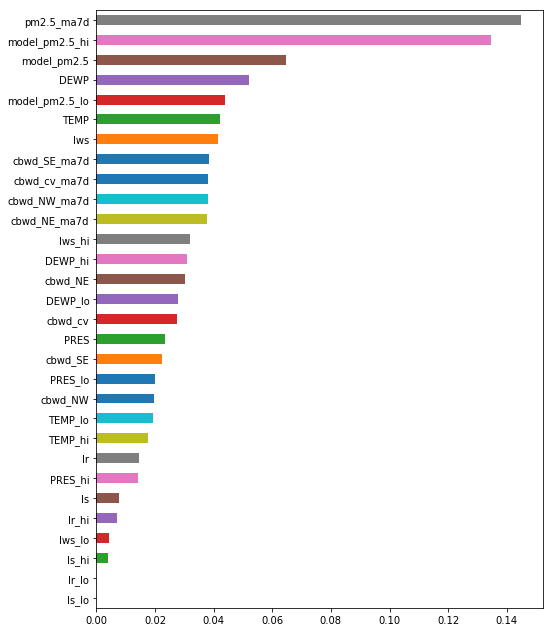

In [135]:
ax = fi.plot.barh(figsize=(8,11))

# 3. Logistic Regression Model<a class="anchor" id="logitmodel"></a>

In [136]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [137]:
reg = LogisticRegression()

In [138]:
t0 = datetime.now()

oof = np.zeros(y.shape[0])
for train, test in cv.split(X,y):
    reg.fit(X[train], y[train])
    oof[test] = reg.predict_proba(X[test])[:,1]
    print("Fold AUC = {:.2%}".format(roc_auc_score(y[test],oof[test])))

print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - t0))

Fold AUC = 87.80%
Fold AUC = 84.97%
Fold AUC = 89.48%
Fold AUC = 92.13%
Fold AUC = 88.92%
Fold AUC = 88.74%
Fold AUC = 93.58%
Fold AUC = 95.08%
Fold AUC = 88.79%
Fold AUC = 93.56%
Time elapsed (hh:mm:ss.ms) 0:00:00.126016


In [139]:
print('OOF AUC Score = {:.2%}'.format(roc_auc_score(y,oof)))

OOF AUC Score = 90.30%


In [140]:
pd.DataFrame({'true':y,'pred':oof}).describe()

,true,pred
count,1819.000000,1819.000000
mean,0.136339,0.137841
std,0.343242,0.217414
min,0.000000,0.000002
25%,0.000000,0.016308
50%,0.000000,0.045737
75%,0.000000,0.136662
max,1.000000,0.997884


In [141]:
print(classification_report(oof>0.2,y))

             precision    recall  f1-score   support

      False       0.90      0.96      0.93      1476
       True       0.73      0.53      0.62       343

avg / total       0.87      0.88      0.87      1819



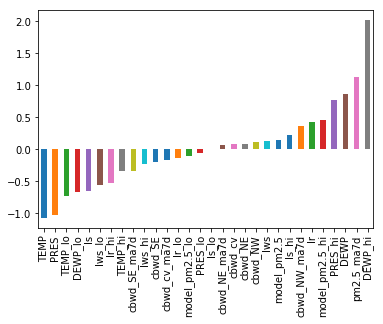

In [142]:
ax = pd.Series(reg.coef_[0],index=predictors).sort_values().plot.bar()

# 4. Warning Level Analysis<a class="anchor" id="warning"></a>
What probability of severe pollution warrants issuance of public warning?

In [143]:
# Use Best Model Only (Logit)
fpr, tpr, thres = roc_curve(y,oof)

In [144]:
tmp = pd.DataFrame(list(roc_curve(y,oof))).T
tmp.columns = ['fpr','tpr','thresholds']

In [145]:
levels = np.arange(0.,0.5,.05)
idx = [np.argmin(np.abs(tmp.thresholds.values - l)) for l in levels]

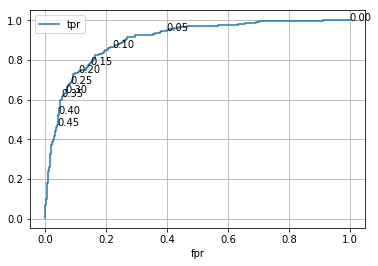

In [146]:
ax = tmp.plot('fpr','tpr',grid=True)
for k, v in tmp.iloc[idx,:].iterrows():
    ax.annotate('{:.2f}'.format(v[2]),v[:2])

In [147]:
tmp = pd.DataFrame({'bin':np.digitize(oof,[0,0.02,0.05,0.1,0.2,0.5,1]),'prob':oof,'true':y})
mat = pd.concat([tmp.groupby(['bin']).prob.agg(['min','max']),
                tmp.groupby(['bin','true']).count().unstack()],axis=1)
mat.columns = ['prob_min','prob_max','false','true']
mat['total'] = mat[['false','true']].sum(axis=1)
mat[['no warn false','no warn true','no warn total']] = mat[['false','true','total']].cumsum()
mat[['warn false','warn true','warn total']] = mat[['false','true','total']].sort_index(ascending=False).cumsum()
mat[['warn false','warn true','warn total']] = mat[['warn false','warn true','warn total']].sub(mat[['false','true','total']].values)

In [148]:
mat.style.format('{:.3f}',subset=['prob_min','prob_max']).\
bar(color='red',subset=['warn false','warn true','warn total']).\
bar(color='lightgreen',subset=['no warn false','no warn true','no warn total'])

,prob_min,prob_max,false,true,total,no warn false,no warn true,no warn total,warn false,warn true,warn total
bin,,,,,,,,,,,
1,0.000,0.020,536,4,540,536,4,540,1035,244,1279
2,0.020,0.050,408,9,417,944,13,957,627,235,862
3,0.050,0.099,282,21,303,1226,34,1260,345,214,559
4,0.100,0.200,184,32,216,1410,66,1476,161,182,343
5,0.200,0.498,110,76,186,1520,142,1662,51,106,157
6,0.501,0.998,51,106,157,1571,248,1819,0,0,0


In [149]:
print('Category Totals')
mat[['false','true','total']].sum()

Category Totals


false    1571
true      248
total    1819
dtype: int64

In [150]:
mat.style.format('{:.3f}',subset=['prob_min','prob_max']).\
applymap(lambda x:'background-color:yellow',subset=pd.IndexSlice[4])

,prob_min,prob_max,false,true,total,no warn false,no warn true,no warn total,warn false,warn true,warn total
bin,,,,,,,,,,,
1,0.000,0.020,536,4,540,536,4,540,1035,244,1279
2,0.020,0.050,408,9,417,944,13,957,627,235,862
3,0.050,0.099,282,21,303,1226,34,1260,345,214,559
4,0.100,0.200,184,32,216,1410,66,1476,161,182,343
5,0.200,0.498,110,76,186,1520,142,1662,51,106,157
6,0.501,0.998,51,106,157,1571,248,1819,0,0,0


### <p> Assuming a two tier warning: early (day-ahead) and day-of
<p> Row 4 appears to be a good choice (early warning when risk measure > 0.20)
* Warn on 343 / 1819 cases
* Expecting 182 / 346 warnings to lead to severe pollution
* Missing 66 / 248 true incidents of severe pollution to be dealt with "day-of" warnings

### Future Work
Develop separate warnings: a) one for severe pollution given that pollution is not severe, and b) another for below severe pollution if in state of severe pollution already.